In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import adjusted_rand_score

RANDOM_STATE = 17

In [4]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [7]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

In [16]:
y = np.concatenate((y_train, y_test))

In [19]:
assert(y_test.shape[0] + y_train.shape[0] == y.shape[0])

In [20]:
X = np.concatenate((X_train, X_test), axis=0)

In [21]:
assert(X_test.shape[0] + X_train.shape[0] == X.shape[0])

In [22]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [27]:
n_classes = np.unique(y).size

# 1 - ходьба
# 2 - подъем вверх по лестнице
# 3 - спуск по лестнице
# 4 - сидение
# 5 - стояние
# 6 - лежание

In [31]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [42]:
pca = PCA(random_state=RANDOM_STATE, n_components=500)
pca.fit(X_scaled)

PCA(n_components=500, random_state=17)

In [49]:
for j in range (65, 75):
    pca = PCA(random_state=RANDOM_STATE, n_components=j)
    pca.fit(X_scaled)
    sum =0
    for i in pca.explained_variance_ratio_:
        sum += i
    print(sum, j)

0.8997840389399007 65
0.9015056286454439 66
0.9032848131223216 67
0.9049679264374882 68
0.9066161031459951 69
0.9081357527781954 70
0.9098409554659125 71
0.9114374034256767 72
0.9128084321526857 73
0.9143515198075105 74


In [50]:
pca = PCA(random_state=RANDOM_STATE, n_components=66)
X_pca = pca.fit(X_scaled)

PCA(n_components=66, random_state=17)

In [53]:
pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]

(0.507382210350133, 0.06239185775196489)

In [70]:
X_pca = pca.transform(X_scaled)

In [81]:
activities = {1:'walking', 2:'laddering_up', 3:'leddering_down', 4:'sitting', 5:'staying', 6:'laying'}
# 1 - ходьба
# 2 - подъем вверх по лестнице
# 3 - спуск по лестнице
# 4 - сидение
# 5 - стояние
# 6 - лежание

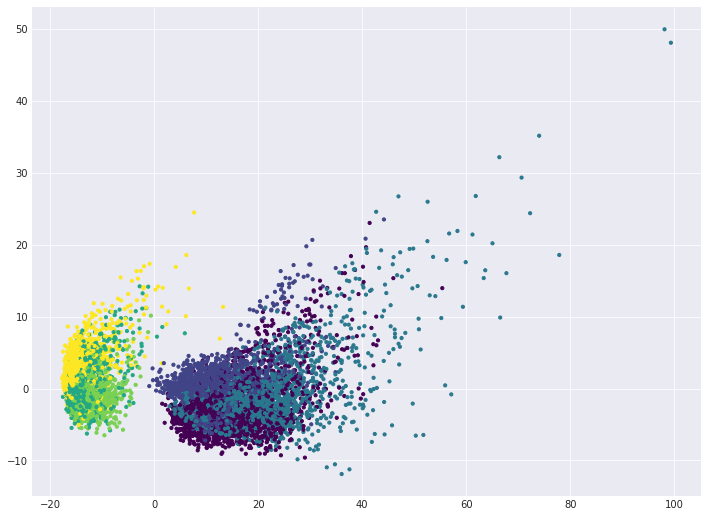

In [109]:
plt.scatter(X_pca[:,0], X_pca[:,2], c=y, s=10, cmap='viridis')

In [98]:
X_kmeans = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit(X_pca)

In [99]:
kmeans_predicted_labels = X_kmeans.predict(X_pca)

In [124]:
adjusted_rand_score(kmeans_predicted_labels, y)

0.4205591780887036

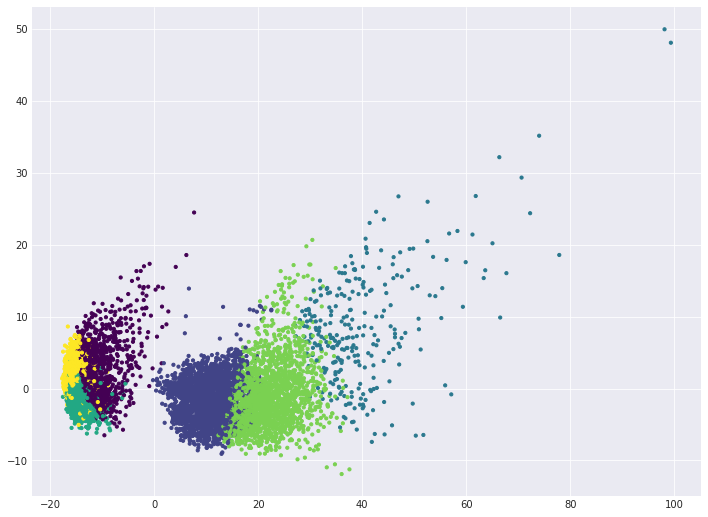

In [108]:
plt.scatter(X_pca[:,0], X_pca[:,2], c=kmeans_predicted_labels, s=10, cmap='viridis')

In [103]:
tab = pd.crosstab(y, kmeans_predicted_labels, margins=True)
tab.index = ['walk', 'ladder up', 
             'ladder down', 'sit', 'stand', 'lay', 'sum']
tab.columns = [name + '_real' for name in tab.index]
tab

,walk_real,ladder up_real,ladder down_real,sit_real,stand_real,lay_real,sum_real
walk,0,904,78,0,740,0,1722
ladder up,2,1241,5,0,296,0,1544
ladder down,0,320,196,0,890,0,1406
sit,443,1,0,1241,0,92,1777
stand,556,0,0,1350,0,0,1906
lay,329,4,0,52,0,1559,1944
sum,1330,2470,279,2643,1926,1651,10299


In [110]:
inertia = []
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

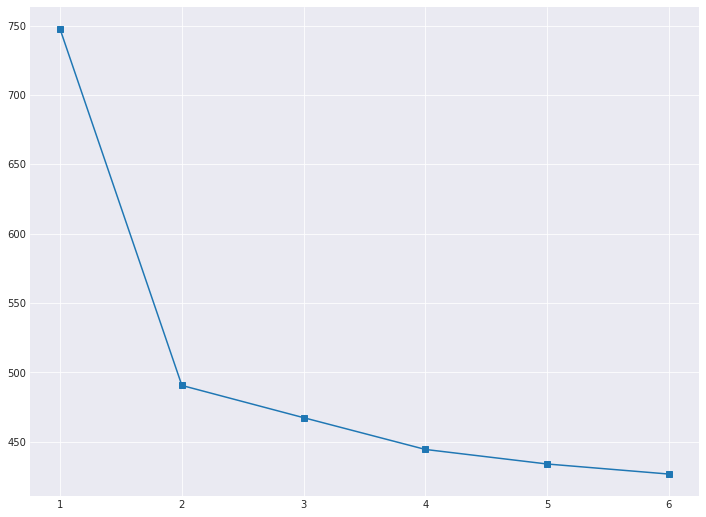

In [111]:
plt.plot(range(1, 7), inertia, marker="s")

In [123]:
for it in range(2, 7):
    ag = AgglomerativeClustering(n_clusters=it, linkage='ward').fit(X_pca)
    print(adjusted_rand_score(ag.labels_, y), it)

0.33253220715485143 2
0.35278708972624556 3
0.3462460951370858 4
0.5308047737009789 5
0.49284557887865715 6


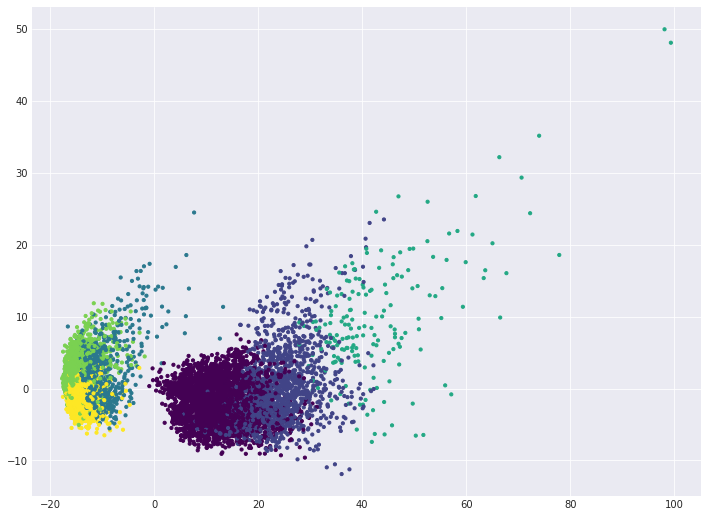

In [125]:
plt.scatter(X_pca[:,0], X_pca[:,2], c=ag.labels_, s=10, cmap='viridis')

In [127]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [129]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
svc_gsv = GridSearchCV(svc,svc_params)

In [133]:
svc_gsv.fit(X_train_scaled, y_train)

C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_bas

GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [135]:
svc_gsv.best_params_

{'C': 0.1}

In [136]:
best_svc = svc_gsv.best_estimator_

In [137]:
svc_train_predicted = best_svc.predict(X_train)
svc_test_predicted = best_svc.predict(X_test)

In [187]:
adjusted_rand_score(svc_test_predicted, y_test)

0.3440259888150147

In [143]:
tab = pd.crosstab(y_test, svc_test_predicted, margins=True)
tab.index = ['walk', 'ladder up', 'ladder down', 'sit', 'stand', 'lay', 'sum']
tab.columns = [name + '_R' for name in tab.index]
tab

,walk_R,ladder up_R,ladder down_R,sit_R,stand_R,lay_R,sum_R
walk,483,0,0,10,3,0,496
ladder up,61,137,0,182,91,0,471
ladder down,155,2,104,96,63,0,420
sit,0,0,0,475,16,0,491
stand,0,0,0,277,255,0,532
lay,0,0,0,119,30,388,537
sum,699,139,104,1159,458,388,2947


In [147]:
tab_val = tab.values

In [169]:
print('Precision:')
for row, i in zip(tab_val, range(1, 7)):
    print(round(row[i-1]/row[6], 3),'\t', activities[i])

Precision:
0.974 	 walking
0.291 	 laddering_up
0.248 	 leddering_down
0.967 	 sitting
0.479 	 staying
0.723 	 laying


In [168]:
print('Recall:')
for i in range(1, 7):
    print(round(tab_val[i][i]/tab_val[6][i], 3),'\t', activities[i])

Recall:
0.986 	 walking
1.0 	 laddering_up
0.41 	 leddering_down
0.557 	 sitting
1.0 	 staying
1.0 	 laying


In [175]:
pca = PCA(random_state=RANDOM_STATE, n_components=66)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

In [176]:
svc_gscv_pca = GridSearchCV(svc,svc_params)

In [177]:
svc_gscv_pca.fit(X_train_pca, y_train)

C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\svm\_bas

GridSearchCV(estimator=LinearSVC(random_state=17),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [179]:
svc_gscv_pca.best_params_

{'C': 1}

In [178]:
svc_pca_best = svc_gscv_pca.best_estimator_

In [181]:
svc_test_predicted_pca = svc_pca_best.predict(X_test_pca)

In [182]:
tab = pd.crosstab(y_test, svc_test_predicted_pca, margins=True)
tab.index = ['walk', 'ladder up', 'ladder down', 'sit', 'stand', 'lay', 'sum']
tab.columns = [name + '_R' for name in tab.index]
tab

,walk_R,ladder up_R,ladder down_R,sit_R,stand_R,lay_R,sum_R
walk,78,34,235,0,0,149,496
ladder up,112,246,66,0,11,36,471
ladder down,175,69,115,3,4,54,420
sit,0,3,25,248,40,175,491
stand,0,3,43,130,190,166,532
lay,0,0,0,408,78,51,537
sum,365,355,484,789,323,631,2947


In [183]:
tab_val = tab.values

In [189]:
adjusted_rand_score(svc_test_predicted_pca, y_test)

0.2321733671631356